In [1]:
import tensorflow as tf

# Check if GPU is available
if tf.test.is_gpu_available():
    print("GPU is available.")
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    print(f"{len(physical_devices)} GPUs detected.")
    
    # List all available devices
    for i, device in enumerate(physical_devices):
        print(f'Device {i}:', device)
else:
    print("GPU is not available.")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is not available.


/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [3]:
# !watch nvidia-smi

In [52]:
import matplotlib.pyplot as plt
from PIL import Image
import tempfile
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import tqdm
from typing import Optional, Callable, Text
import typing_extensions

from tf_prioritized_replay_buffer import TFPrioritizedReplayBuffer

from tf_agents.agents import tf_agent, data_converter
from tf_agents.agents.ddpg import ddpg_agent, actor_network, critic_network
from tf_agents.agents.td3 import td3_agent
from tf_agents.agents.dqn import dqn_agent
from tf_agents.agents.ppo import ppo_agent
from tf_agents.environments import suite_gym, tf_py_environment
from tf_agents.agents.ddpg.actor_network import ActorNetwork
from tf_agents.networks import actor_distribution_network, value_network, q_network
from tf_agents.specs import tensor_spec
from tf_agents.policies import random_tf_policy
from tf_agents.trajectories import trajectory, time_step as ts
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.policies import actor_policy, greedy_policy, q_policy, epsilon_greedy_policy
from tf_agents.metrics import tf_metrics
from tf_agents.utils import common
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver
from tf_agents.drivers import dynamic_step_driver, dynamic_episode_driver
from tf_agents.distributions import utils as distribution_utils
from tf_agents.agents.sac import sac_agent
from tf_agents.typing import types
import collections
import gin
import tf_agents.networks as network

In [2]:
Literal = typing_extensions.Literal


class BehavioralCloningLossInfo(collections.namedtuple(
    'BehavioralCloningLossInfo', ('loss'))):
  pass


@gin.configurable
class BehavioralCloningAgent(tf_agent.TFAgent):
  

  def __init__(
      self,
      time_step_spec: ts.TimeStep,
      action_spec: types.NestedTensorSpec,
      cloning_network: network.Network,
      optimizer: types.Optimizer,
      num_outer_dims: Literal[1, 2] = 2,  # pylint: disable=bad-whitespace
      epsilon_greedy: types.Float = 0.1,
      loss_fn: Optional[Callable[[types.NestedTensor, bool],
                                 types.Tensor]] = None,
      gradient_clipping: Optional[types.Float] = None,
      # Params for debugging.
      debug_summaries: bool = False,
      summarize_grads_and_vars: bool = False,
      train_step_counter: Optional[tf.Variable] = None,
      name: Optional[Text] = None):
    
    tf.Module.__init__(self, name=name)
    self._cloning_network = cloning_network
    self._optimizer = optimizer
    self._gradient_clipping = gradient_clipping

    action_spec = tensor_spec.from_spec(action_spec)
    flat_action_spec = tf.nest.flatten(action_spec)
    continuous_specs = [tensor_spec.is_continuous(s) for s in flat_action_spec]

    if not flat_action_spec:
      raise ValueError('The `action_spec` must contain at least one action.')

    single_discrete_scalar_action = (
        len(flat_action_spec) == 1 and
        flat_action_spec[0].shape.rank == 0 and
        not tensor_spec.is_continuous(flat_action_spec[0]))
    single_continuous_action = (
        len(flat_action_spec) == 1 and
        tensor_spec.is_continuous(flat_action_spec[0]))

    if (not loss_fn and not single_discrete_scalar_action and
        not single_continuous_action):
      raise ValueError(
          'A `loss_fn` must be provided unless there is a single, scalar '
          'discrete action or a single (scalar or non-scalar) continuous '
          'action.')

    self._network_output_spec = cloning_network.create_variables(
        time_step_spec.observation)

    # If there is a mix of continuous and discrete actions we want to use an
    # actor policy so we can use the `setup_as_continuous` method as long as the
    # user provided a custom loss_fn which we verified above.
    if any(continuous_specs):
      policy, collect_policy = self._setup_as_continuous(
          time_step_spec, action_spec, loss_fn)
    else:
      policy, collect_policy = self._setup_as_discrete(time_step_spec,
                                                       action_spec, loss_fn,
                                                       epsilon_greedy)

    super(BehavioralCloningAgent, self).__init__(
        time_step_spec,
        action_spec,
        policy,
        collect_policy,
        train_sequence_length=None,
        debug_summaries=debug_summaries,
        summarize_grads_and_vars=summarize_grads_and_vars,
        train_step_counter=train_step_counter)

    self._as_trajectory = data_converter.AsTrajectory(
        self.data_context, sequence_length=None,
        num_outer_dims=num_outer_dims)

  @property
  def cloning_network(self):
    return self._cloning_network

  def _discrete_loss(self, experience, training=False):
    batch_size = (
        tf.compat.dimension_value(experience.step_type.shape[0]) or
        tf.shape(experience.step_type)[0])

    network_state = self._cloning_network.get_initial_state(batch_size)
    action, _ = self._cloning_network(
        experience.observation,
        step_type=experience.step_type,
        training=training,
        network_state=network_state)

    # Get logits if the output of the cloning network is a distribution.
    if isinstance(action, tfp.distributions.Distribution):
      bc_logits = action.logits_parameter()
    else:
      bc_logits = action

    def loss(action, bc_logits, spec):
      # Subtract the minimum so that we get a proper cross entropy loss on
      # [0, maximum - minimum).
      return tf.nn.sparse_softmax_cross_entropy_with_logits(
          labels=action - spec.minimum, logits=bc_logits)

    losses = tf.nest.map_structure(loss, experience.action, bc_logits,
                                   self.action_spec)
    losses = tf.nest.flatten(losses)
    return tf.add_n(losses)

  def _continuous_loss_fn(self, experience, training: bool = False):
    batch_size = (
        tf.compat.dimension_value(experience.step_type.shape[0]) or
        tf.shape(experience.step_type)[0])
    network_state = self._cloning_network.get_initial_state(batch_size)
    bc_output, _ = self._cloning_network(
        experience.observation,
        step_type=experience.step_type,
        training=training,
        network_state=network_state)

    if isinstance(bc_output, tfp.distributions.Distribution):
      bc_action = bc_output.sample()
    else:
      bc_action = bc_output

    losses = tf.nest.map_structure(tf.losses.mse, experience.action, bc_action)
    losses = tf.nest.flatten(losses)
    return tf.add_n(losses)

  def _setup_as_discrete(self, time_step_spec, action_spec, loss_fn,
                         epsilon_greedy):
    self._bc_loss_fn = loss_fn or self._discrete_loss

    if any(isinstance(d, distribution_utils.DistributionSpecV2) for
           d in tf.nest.flatten([self._network_output_spec])):
      # If the output of the cloning network contains a distribution.
      base_policy = actor_policy.ActorPolicy(time_step_spec, action_spec,
                                             self._cloning_network)
    else:
      # If the output of the cloning network is logits.
      base_policy = q_policy.QPolicy(
          time_step_spec,
          action_spec,
          q_network=self._cloning_network,
          validate_action_spec_and_network=False)
    policy = greedy_policy.GreedyPolicy(base_policy)
    collect_policy = epsilon_greedy_policy.EpsilonGreedyPolicy(
        base_policy, epsilon=epsilon_greedy)
    return policy, collect_policy

  def _setup_as_continuous(self, time_step_spec, action_spec, loss_fn):
    self._bc_loss_fn = loss_fn or self._continuous_loss_fn
    collect_policy = actor_policy.ActorPolicy(
        time_step_spec, action_spec, actor_network=self._cloning_network)
    policy = greedy_policy.GreedyPolicy(collect_policy)
    return policy, collect_policy

  def _loss(self, experience, weights=None, training: bool = False):
    experience = self._as_trajectory(experience)

    per_example_loss = self._bc_loss_fn(experience, training=training)  # pytype: disable=wrong-keyword-args  # dynamic-method-lookup
    aggregated_losses = common.aggregate_losses(
        per_example_loss=per_example_loss,
        sample_weight=weights,
        regularization_loss=self._cloning_network.losses)

    return tf_agent.LossInfo(
        loss=aggregated_losses.total_loss,
        extra=BehavioralCloningLossInfo(per_example_loss))

  def _train(self, experience, weights=None):
    experience = self._as_trajectory(experience)

    with tf.GradientTape() as tape:
      per_example_loss = self._bc_loss_fn(experience, training=True)  # pytype: disable=wrong-keyword-args  # dynamic-method-lookup

      aggregated_losses = common.aggregate_losses(
          per_example_loss=per_example_loss,
          sample_weight=weights,
          regularization_loss=self._cloning_network.losses)

    self._apply_loss(aggregated_losses,
                     variables_to_train=self._cloning_network.trainable_weights,
                     tape=tape,
                     optimizer=self._optimizer)

    self.train_step_counter.assign_add(1)
    return tf_agent.LossInfo(aggregated_losses.total_loss,
                             BehavioralCloningLossInfo(per_example_loss))

In [6]:
devices = tf.config.list_physical_devices('GPU')
print(devices)

[]


In [3]:
def compute_avg_return(environment, policy, num_episodes=10):
    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

In [4]:
def plot_results(losses, average_returns):
    # Convert actions_taken to a 1D list
    # actions_taken = [item[0][0] for item in actions_taken]

    # Plotting actions taken
    plt.figure()
    plt.plot(actions_taken)
    plt.title('Actions over time')
    plt.xlabel('Time step')
    plt.ylabel('Action')
    plt.show()

    # Plotting losses
    steps, loss_vals = zip(*losses)
    plt.figure()
    plt.plot(steps, loss_vals)
    plt.title('Loss over time')
    plt.xlabel('Time step')
    plt.ylabel('Loss')
    plt.show()

    # Plotting average returns
    steps, avg_returns = zip(*average_returns)
    plt.figure()
    plt.plot(steps, avg_returns)
    plt.title('Average Return over time')
    plt.xlabel('Time step')
    plt.ylabel('Average Return')
    plt.show()

In [5]:
def plot_average_episode_length(episode_lengths, eval_interval):
    """Plot the average episode length over time."""
    steps = list(range(0, len(episode_lengths) * eval_interval, eval_interval))
    plt.figure(figsize=(10, 5))
    plt.plot(steps, episode_lengths)
    plt.xlabel('Training Steps')
    plt.ylabel('Average Episode Length')
    plt.title('Average Episode Length over Training Steps')
    plt.grid(True)
    plt.show()

### SAC

In [6]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = 'cuda:1'

env_name = 'CarRacing-v1'
train_env = suite_gym.load(env_name)
train_env = tf_py_environment.TFPyEnvironment(train_env)

In [7]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6426466046079808779
xla_global_id: -1
]


In [8]:
eval_env_name = 'CarRacing-v1'
eval_env = suite_gym.load(eval_env_name)
eval_env = tf_py_environment.TFPyEnvironment(eval_env)

In [9]:
# Parameters
num_iterations = 10000
initial_collect_steps = 1000
collect_steps_per_iteration = 1
replay_buffer_max_length = 100000
batch_size = 64
learning_rate = 1e-3
log_interval = 50
eval_interval = 500
num_eval_episodes = 10 

# Hyperparameters
critic_learning_rate = 3e-4
actor_learning_rate = 3e-4
alpha_learning_rate = 3e-4
target_update_tau = 0.005
target_update_period = 1
gamma = 0.99
reward_scale_factor = 1.0
gradient_clipping = None
debug_summaries = False
summarize_grads_and_vars = False

In [11]:
# Actor network
sac_actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=(256, 256))

In [12]:
# Critic network
sac_critic_net = critic_network.CriticNetwork(
    (train_env.observation_spec(), train_env.action_spec()),
    observation_fc_layer_params=None,
    action_fc_layer_params=None,
    joint_fc_layer_params=(256, 256))

In [13]:
# SAC Agent
global_step = tf.compat.v1.train.get_or_create_global_step()
sac_tf_agent = sac_agent.SacAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=sac_actor_net,
    critic_network=sac_critic_net,
    actor_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=actor_learning_rate),
    critic_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=critic_learning_rate),
    alpha_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=alpha_learning_rate),
    target_update_tau=target_update_tau,
    target_update_period=target_update_period,
    td_errors_loss_fn=common.element_wise_squared_loss,
    gamma=gamma,
    reward_scale_factor=reward_scale_factor,
    gradient_clipping=gradient_clipping,
    debug_summaries=debug_summaries,
    summarize_grads_and_vars=summarize_grads_and_vars,
    train_step_counter=global_step)
sac_tf_agent.initialize()

In [14]:
# Replay Buffer
sac_replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=sac_tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

In [10]:
def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)
    buffer.add_batch(traj)

In [16]:
for _ in range(10):
    collect_step(train_env, sac_tf_agent.collect_policy, sac_replay_buffer)

Track generation: 1123..1412 -> 289-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1059..1328 -> 269-tiles track


In [17]:
sac_dataset = sac_replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=64, 
    num_steps=2).prefetch(3)

sac_iterator = iter(sac_dataset)

Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [22]:
# Variables to store data for plotting
actions_taken = []
losses = []
average_returns = []
episode_lengths = []

# For tracking episode length
episode_length = 0

# Assuming `num_iterations` is the total number of training steps
for _ in (range(num_iterations)):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, sac_tf_agent.collect_policy, sac_replay_buffer)

    # If the episode ended, record its length and reset the count
    time_step = train_env.current_time_step()
    if time_step.is_last():
      episode_lengths.append(episode_length)
      episode_length = 0
    else:
      episode_length += 1

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(sac_iterator)
  train_loss = sac_tf_agent.train(experience).loss

  step = sac_tf_agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))
    losses.append((step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, sac_tf_agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    average_returns.append((step, avg_return))

step = 50: loss = 0.12393078207969666
step = 100: loss = 0.1985519826412201
step = 150: loss = 0.8242680430412292
step = 200: loss = -0.9108748435974121
step = 250: loss = -0.9327499866485596
step = 300: loss = -0.9570177793502808
step = 350: loss = -1.7502999305725098
step = 400: loss = -2.341069459915161
step = 450: loss = -3.0860066413879395
step = 500: loss = -2.6715502738952637
Track generation: 1057..1333 -> 276-tiles track
Track generation: 954..1205 -> 251-tiles track
Track generation: 1079..1353 -> 274-tiles track
Track generation: 1059..1328 -> 269-tiles track
Track generation: 1277..1600 -> 323-tiles track
Track generation: 1312..1644 -> 332-tiles track
Track generation: 1260..1588 -> 328-tiles track
Track generation: 1087..1363 -> 276-tiles track
Track generation: 1219..1528 -> 309-tiles track
Track generation: 1126..1416 -> 290-tiles track
step = 500: Average Return = -68.89639282226562
step = 550: loss = -3.134544610977173
step = 600: loss = -3.6478328704833984
step = 650

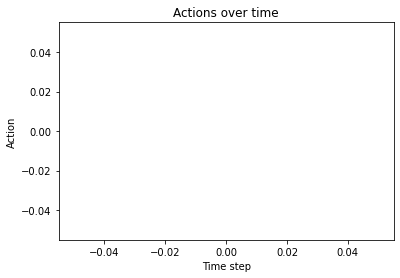

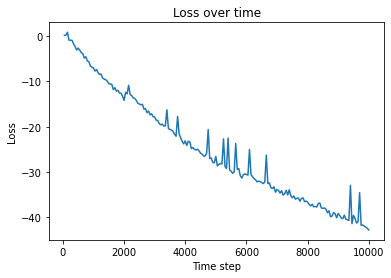

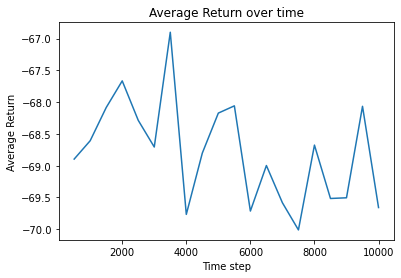

In [20]:
plot_results(actions_taken, losses, average_returns)

### PPO

In [14]:
ppo_actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=(100,))
ppo_value_net = value_network.ValueNetwork(train_env.observation_spec())

In [15]:
# Agent
ppo_tf_agent = ppo_agent.PPOAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=0.001),
    actor_net=ppo_actor_net,
    value_net=ppo_value_net,
    num_epochs=10)
ppo_tf_agent.initialize()

In [16]:
# Metrics and Evaluation
ppo_replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=ppo_tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)
ppo_dataset = ppo_replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)
ppo_iterator = iter(ppo_dataset)

Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.


Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [17]:
# Collect data
def collect_episode(environment, policy, num_episodes, replay_buffer):

    episode_counter = 0
    environment.reset()

    while episode_counter < num_episodes:
        time_step = environment.current_time_step()
        action_step = policy.action(time_step)
        next_time_step = environment.step(action_step.action)
        traj = trajectory.from_transition(time_step, action_step, next_time_step)

        # Add trajectory to the replay buffer
        replay_buffer.add_batch(traj)

        if traj.is_boundary():
            episode_counter += 1

In [18]:
# Training loop
ppo_tf_agent.train = common.function(ppo_tf_agent.train)
ppo_tf_agent.train_step_counter.assign(0)

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=0>

In [ ]:
# Variables to store data for plotting
ppo_losses = []
ppo_average_returns = []
ppo_episode_lengths = []

# For tracking episode length
ppo_episode_length = 0

print(num_iterations)

# Wrap the training loop in tqdm
# pbar = (range(num_iterations))
for _ in (range(num_iterations)):
# with tf.device('/GPU:0'):
    # for _ in pbar:
    # Collect a few episodes using collect_policy and save to the replay buffer.
    for _ in range(collect_steps_per_iteration):
        collect_episode(train_env, ppo_tf_agent.collect_policy, 1, ppo_replay_buffer)

    # Use data from the buffer and update the agent's network.
    experience, unused_info = next(ppo_iterator)
    train_loss = ppo_tf_agent.train(experience).loss

    step = ppo_tf_agent.train_step_counter.numpy()
    
    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))
        ppo_losses.append((step, train_loss))
    
    # Store metrics
    # ppo_losses.append(train_loss)

    # Update progress bar
    # pbar.set_description(f'Step: {step}, Loss: {train_loss}')

    # If the episode ended, record its length and reset the count
    time_step = train_env.current_time_step()
    if time_step.is_last():
      ppo_episode_lengths.append(episode_length)
      ppo_episode_length = 0
    else:
      ppo_episode_length += 1

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, ppo_tf_agent.policy, num_eval_episodes)
        ppo_average_returns.append(avg_return)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))

# Print metrics
print(f'Final Loss: {ppo_losses[-1]}')
print(f'Final Average Return: {ppo_average_returns[-1]}')
print(f'Final Average Episode Length: {np.mean(ppo_episode_lengths)}')

10000
Track generation: 1129..1415 -> 286-tiles track
Track generation: 1125..1410 -> 285-tiles track
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


Track generation: 1207..1515 -> 308-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1027..1292 -> 265-tiles track
Track generation: 1179..1479 -> 300-tiles track
Track generation: 1226..1536 -> 310-tiles track
Track generation: 1026..1294 -> 268-tiles track
Track generation: 1248..1564 -> 316-tiles track
Track generation: 1120..1404 -> 284-tiles track
Track generation: 1087..1363 -> 276-tiles track
Track generation: 1055..1331 -> 276-tiles track
step = 50: loss = 1248.8536376953125
Track generation: 1136..1424 -> 288-tiles track
Track generation: 1143..1433 -> 290-tiles track
Track generation: 1115..1398 -> 283-tiles track
Track generation: 1236..1549 -> 313-tiles track
Track generation: 1205..1520 -> 315-tiles track
Track generation: 1323..1658 -> 335-tiles track
Track generation: 1176..1482 -> 306-tiles track
Track generation: 1133..1420 -> 287-tiles track
Track generation: 1062..1333 -> 271-tiles track
Track generation: 1

### DDPG

In [11]:
ddpg_actor_net = actor_network.ActorNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=(400, 300))

ddpg_critic_net = critic_network.CriticNetwork(
    (train_env.observation_spec(), train_env.action_spec()),
    observation_fc_layer_params=None,
    action_fc_layer_params=None,
    joint_fc_layer_params=(400, 300))

In [12]:
global_step = tf.compat.v1.train.get_or_create_global_step()

In [13]:
tf_ddpg_agent = ddpg_agent.DdpgAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=ddpg_actor_net,
    critic_network=ddpg_critic_net,
    actor_optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=0.001),
    critic_optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=0.001),
    ou_stddev=0.2,
    ou_damping=0.15,
    target_update_tau=0.05,
    target_update_period=5,
    td_errors_loss_fn=common.element_wise_squared_loss,
    gamma=0.99,
    reward_scale_factor=1.0,
    gradient_clipping=None,
    debug_summaries=False,
    summarize_grads_and_vars=False,
    train_step_counter=global_step)
tf_ddpg_agent.initialize()

In [14]:
ddpg_replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_ddpg_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=100000)

In [15]:
for _ in range(100):
    collect_step(train_env, tf_ddpg_agent.collect_policy, ddpg_replay_buffer)

Track generation: 1090..1366 -> 276-tiles track


In [16]:
ddpg_dataset = ddpg_replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=64, 
    num_steps=2).prefetch(3)

ddpg_iterator = iter(ddpg_dataset)

Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [17]:
# Variables to store data for plotting
actions_taken = []
losses = []
average_returns = []
episode_lengths = []

# For tracking episode length
episode_length = 0
num_iterations = 2000
# Assuming `num_iterations` is the total number of training steps
for _ in (range(num_iterations)):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, tf_ddpg_agent.collect_policy, ddpg_replay_buffer)

    # If the episode ended, record its length and reset the count
    time_step = train_env.current_time_step()
    if time_step.is_last():
      episode_lengths.append(episode_length)
      episode_length = 0
    else:
      episode_length += 1

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(ddpg_iterator)
  train_loss = tf_ddpg_agent.train(experience).loss

  step = tf_ddpg_agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))
    losses.append((step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, tf_ddpg_agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    average_returns.append((step, avg_return))

step = 50: loss = 0.26499271392822266
step = 100: loss = 3.8873634338378906
step = 150: loss = 0.445844441652298
step = 200: loss = 0.023079926148056984
step = 250: loss = 0.2362213432788849
step = 300: loss = 0.20872554183006287
step = 350: loss = 0.03534311056137085
step = 400: loss = 0.17863626778125763
step = 450: loss = 0.20218388736248016
step = 500: loss = 0.025153128430247307
Track generation: 995..1257 -> 262-tiles track
Track generation: 1179..1478 -> 299-tiles track
Track generation: 1031..1293 -> 262-tiles track
Track generation: 1103..1383 -> 280-tiles track
Track generation: 1127..1421 -> 294-tiles track
Track generation: 1096..1374 -> 278-tiles track
Track generation: 962..1214 -> 252-tiles track
Track generation: 1160..1463 -> 303-tiles track
Track generation: 1195..1498 -> 303-tiles track
Track generation: 1211..1518 -> 307-tiles track
step = 500: Average Return = -92.51594543457031
step = 550: loss = 0.07792608439922333
step = 600: loss = 0.4118463695049286
step = 650

In [33]:
import matplotlib.pyplot as plt
import numpy as np

def ppo_plot_results(average_returns):
    # Plotting losses
    # plt.figure()
    # plt.plot(losses)
    # plt.xlabel("Step")
    # plt.ylabel("Loss")
    # plt.title("Losses")

    # Plotting average returns
    steps = np.arange(len(average_returns))
    avg_returns = np.array(average_returns)

    plt.figure()
    plt.plot(avg_returns)
    plt.title('Average Return over time')
    plt.xlabel('Time step')
    plt.ylabel('Average Return')
    plt.show()


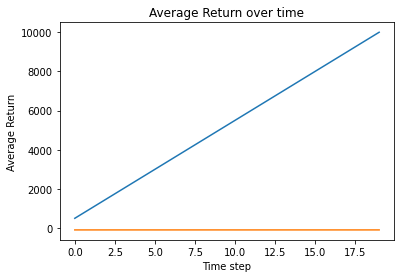

In [34]:
ppo_plot_results(average_returns)

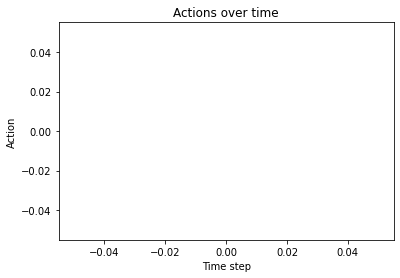

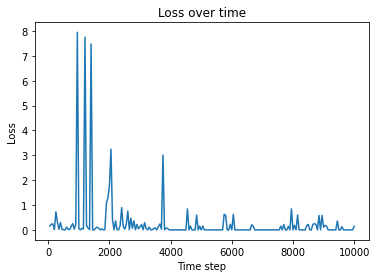

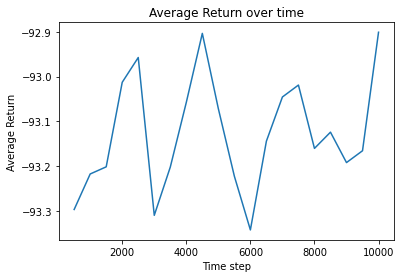

In [37]:
plot_results(losses,average_returns)

In [52]:
# import os
# import gym
# import matplotlib.pyplot as plt
# os.environ["SDL_VIDEODRIVER"] = "dummy"
# from IPython.display import clear_output

# env = gym.make("LunarLander-v2")#, render_mode="human")
# env.action_space.seed(42)

# observation, info = env.reset(seed=42, return_info=True)

# for _ in range(10):
#     observation, reward, done, info = env.step(env.action_space.sample())

#     if done:
#         observation, info = env.reset(return_info=True)
        
#     clear_output(wait=True)
#     plt.imshow( env.render(mode='rgb_array') )
#     plt.show()

# env.close()

In [57]:
# import gym
# import imageio
# import os

# # Create the gym environment
# env = gym.make('CartPole-v1')

# # Run the environment and capture frames
# observation = env.reset()
# frames = []
# for t in range(1000000000000):
#     # Render to frames buffer
#     frames.append(env.render(mode="rgb_array"))
#     action = env.action_space.sample()
#     _, _, done, _ = env.step(action)
#     if done:
#         break
# env.close()

# # Save frames as individual images
# output_dir = 'frames'
# os.makedirs(output_dir, exist_ok=True)
# for i, frame in enumerate(frames):
#     imageio.imwrite(f'{output_dir}/frame_{i:04d}.png', frame)

# # Convert images to a video using ffmpeg
# output_video = 'gym_animation.mp4'
# ffmpeg_command = f'ffmpeg -y -r 5 -i {output_dir}/frame_%04d.png -vcodec libx264 -pix_fmt yuv420p {output_video}'
# os.system(ffmpeg_command)

# print(f"Video saved as {output_video}")


In [ ]:
plot_results(actions_taken, losses, average_returns)

## NOW THAT THE DDQN AGENT HAS A BETTER POLICY TO INTERACT WITH THE ENVIRONMENT, LETS COLLECT SOME MORE EXPERIENCES AND STORE IT IN A NEW REPLAY BUFFER. THIS IS THE SET OF EXPERIENECS THAT THE BEHAVIORAL CLONING AGENT WILL LEARN FROM.

In [18]:
# Create a replay buffer to store trajectories
training_replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_ddpg_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)
max_interactions = 1000
num_interactions = 0
counter = 0
while num_interactions < max_interactions:
    print(counter)
    counter += 1
    time_step = train_env.reset()
    episode_step = 0
    while not time_step.is_last():
        action_step = tf_ddpg_agent.collect_policy.action(time_step)  # Use agent's collect_policy
        next_time_step = train_env.step(action_step.action)
        traj = trajectory.from_transition(time_step, action_step, next_time_step)

        training_replay_buffer.add_batch(traj)

        time_step = next_time_step
        episode_step += 1
        num_interactions += 1

        if episode_step >= train_env.pyenv.envs[0].env.spec.max_episode_steps:
            break

# Print the number of interactions and replay buffer size
print(f'Number of interactions: {num_interactions}')
print(f'Replay buffer size: {training_replay_buffer.num_frames().numpy()}')

0
Track generation: 1169..1465 -> 296-tiles track
Number of interactions: 1000
Replay buffer size: 1000


## INITIALIZE BEHAVIORAL CLONING AGENT

In [19]:
observation_spec = train_env.observation_spec()
action_spec = train_env.action_spec()

In [20]:
# Initialize the Actor Distribution Network
behavioral_actor_net = actor_network.ActorNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=(400, 300))

In [21]:
# Optimizer
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

In [22]:
# Initialize the Behavioral Cloning Agent
train_step_counter = tf.Variable(0)
agent_b = BehavioralCloningAgent(
    time_step_spec=ts.time_step_spec(observation_spec),
    action_spec=action_spec,
    cloning_network=behavioral_actor_net,
    optimizer=optimizer,
    train_step_counter=train_step_counter)

In [23]:
# Convert the replay buffer to a TensorFlow dataset
experience_dataset = training_replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=64,
    num_steps=1).prefetch(3)

In [24]:
experience_dataset_iterator = iter(experience_dataset)

In [25]:
# Make the Behavioral Cloning Agent's train function a TensorFlow graph function
agent_b.train = common.function(agent_b.train)

In [50]:
# Run the training loop
num_iterations = 20000  # adjust this to your needs
# Create a list to store the loss values
train_loss_list = []
for i in range(num_iterations):
    # Sample a batch of experiences from the replay buffer
    trajectories, _ = next(experience_dataset_iterator)
    
    # Train the agent on the sampled experiences
    train_loss = agent_b.train(trajectories)
    
    # Append the current loss value to the list
    train_loss_list.append(train_loss.loss)
    
    # Print the current iteration number and the training loss every 100 iterations
    if i % 100 == 0:
        print('Iteration:', i, 'Training loss:', train_loss.loss.numpy())

Iteration: 0 Training loss: 0.16181742
Iteration: 100 Training loss: 0.049642816
Iteration: 200 Training loss: 0.04212077
Iteration: 300 Training loss: 0.065904975
Iteration: 400 Training loss: 0.055609576
Iteration: 500 Training loss: 0.051896922
Iteration: 600 Training loss: 0.06275069
Iteration: 700 Training loss: 0.048975695
Iteration: 800 Training loss: 0.0690615
Iteration: 900 Training loss: 0.05448527
Iteration: 1000 Training loss: 0.05278561
Iteration: 1100 Training loss: 0.052608583
Iteration: 1200 Training loss: 0.06015053
Iteration: 1300 Training loss: 0.08413427
Iteration: 1400 Training loss: 0.074382015
Iteration: 1500 Training loss: 0.08851105
Iteration: 1600 Training loss: 0.060261637
Iteration: 1700 Training loss: 0.06772536
Iteration: 1800 Training loss: 0.04440382
Iteration: 1900 Training loss: 0.0631614
Iteration: 2000 Training loss: 0.04519383
Iteration: 2100 Training loss: 0.059999123
Iteration: 2200 Training loss: 0.067204446
Iteration: 2300 Training loss: 0.06816

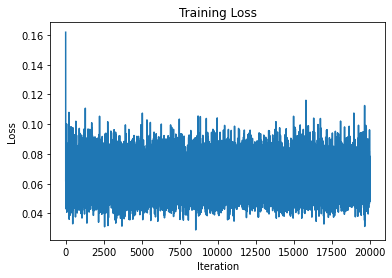

In [27]:
# Plot the training loss
plt.plot(train_loss_list)
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

## LET'S FIND OUT IF OUT BEHAVIORAL CLONING AGENT INTERACTS WITH CARTPOLE BETTER AFTER TRAINING ON THE REPLAY BUFFER FULL OF EEXPERIENCES

In [28]:
# Reset the environment
eval_env.reset()

# Initialize variables
total_reward = 0
rewards = []
average_rewards = []
num_eval_episodes = 500
# Collect rewards by interacting with the environment
for step in range(num_eval_episodes):
    print(step)
    time_step = eval_env.current_time_step()
    while not time_step.is_last():
        # Get the agent's action based on the current time step
        action_step = agent_b.policy.action(time_step)
        
        # Apply the action to the environment
        next_time_step = eval_env.step(action_step.action)
        
        # Collect the reward
        reward = next_time_step.reward
        total_reward += reward
        
        # Update the time step
        time_step = next_time_step
    
    # Append the total reward for the episode
    rewards.append(total_reward)
    total_reward = 0
    
    # Calculate the average reward
    average_reward = sum(rewards) / len(rewards)
    average_rewards.append(average_reward)

Track generation: 1006..1267 -> 261-tiles track
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
26

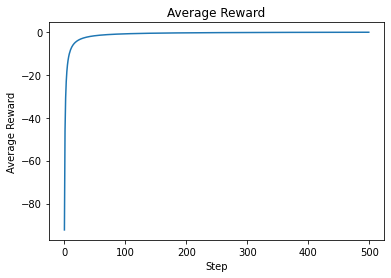

In [29]:
# Plot the final average reward
plt.plot(average_rewards)
plt.title('Average Reward')
plt.xlabel('Step')
plt.ylabel('Average Reward')
plt.show()

In [61]:
# Initialize the Critic Network
behavioral_critic_net = critic_network.CriticNetwork(
    (observation_spec, action_spec),
    observation_fc_layer_params=None,
    action_fc_layer_params=None,
    joint_fc_layer_params=(100,))

In [62]:
behavioral_ddpg_agent = ddpg_agent.DdpgAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=behavioral_actor_net,
    critic_network=behavioral_critic_net,
    actor_optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=0.001),
    critic_optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=0.001),
    ou_stddev=0.2,
    ou_damping=0.15,
    target_update_tau=0.05,
    target_update_period=5,
    td_errors_loss_fn=common.element_wise_squared_loss,
    gamma=0.99,
    reward_scale_factor=1.0,
    gradient_clipping=None,
    debug_summaries=False,
    summarize_grads_and_vars=False,
    train_step_counter=global_step)
behavioral_ddpg_agent.initialize()

In [54]:
per_replay_buffer = TFPrioritizedReplayBuffer(
    data_spec=behavioral_ddpg_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

# behavioral_replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
#     data_spec=behavioral_ddpg_agent.collect_data_spec,
#     batch_size=train_env.batch_size,
#     max_length=100000)

In [55]:
# Collect experiences using the behavioral cloning agent
num_eval_episodes = 100
collect_experience(eval_env, agent_b.policy, per_replay_buffer, num_eval_episodes)

0
Track generation: 1083..1357 -> 274-tiles track
1
Track generation: 1219..1528 -> 309-tiles track
2
Track generation: 1124..1409 -> 285-tiles track
3
Track generation: 1291..1618 -> 327-tiles track
4
Track generation: 1164..1466 -> 302-tiles track
5
Track generation: 1252..1569 -> 317-tiles track
6
Track generation: 1140..1429 -> 289-tiles track
7
Track generation: 972..1219 -> 247-tiles track
8
Track generation: 1245..1560 -> 315-tiles track
9
Track generation: 1127..1413 -> 286-tiles track
10
Track generation: 969..1223 -> 254-tiles track
11
Track generation: 1084..1359 -> 275-tiles track
12
Track generation: 1078..1352 -> 274-tiles track
13
Track generation: 1072..1344 -> 272-tiles track
14
Track generation: 1212..1520 -> 308-tiles track
15
Track generation: 1120..1404 -> 284-tiles track
16
Track generation: 1174..1472 -> 298-tiles track
17
Track generation: 1153..1452 -> 299-tiles track
18
Track generation: 1239..1553 -> 314-tiles track
19
Track generation: 1135..1423 -> 288-tile

In [56]:
# Define a function to collect experiences
def collect_experience(environment, policy, buffer, num_episodes):
    counter = 0
    for _ in range(num_episodes):
        print(counter)
        counter += 1
        time_step = environment.reset()
        while not time_step.is_last():
    
            action_step = policy.action(time_step)
            next_time_step = environment.step(action_step.action)
            traj = trajectory.from_transition(time_step, action_step, next_time_step)
            buffer.add_batch(traj)
            time_step = next_time_step

In [57]:
# Reset the train environment
train_env.reset()

Track generation: 1153..1445 -> 292-tiles track


TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 96, 96, 3), dtype=uint8, numpy=
array([[[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        ...,

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]]], dt

In [58]:
# Create an iterator for the replay buffer
behavioral_dataset = per_replay_buffer.as_dataset(num_parallel_calls=3, sample_batch_size=64, num_steps=2)
behavioral_dataset = behavioral_dataset.prefetch(3)
iterator = iter(behavioral_dataset)

In [59]:
# Variables to store data for plotting
behavioral_losses = []
behavioral_average_returns = []
behavioral_episode_lengths = []

# Reset the train step counter
behavioral_ddpg_agent.train_step_counter.assign(0)

# For tracking episode length
episode_length = 0
num_iterations = 2000
num_eval_episodes = 20

# Assuming `num_iterations` is the total number of training steps
for _ in (range(num_iterations)):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent_b.collect_policy, per_replay_buffer)

    # If the episode ended, record its length and reset the count
    time_step = train_env.current_time_step()
    if time_step.is_last():
      behavioral_episode_lengths.append(episode_length)
      episode_length = 0
    else:
      episode_length += 1

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(ddpg_iterator)
  train_loss = behavioral_ddpg_agent.train(experience).loss

  step = behavioral_ddpg_agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))
    behavioral_losses.append((step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, behavioral_ddpg_agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    behavioral_average_returns.append((step, avg_return))

step = 50: loss = 0.3580203056335449
step = 100: loss = 0.10731812566518784
step = 150: loss = 0.209431990981102
step = 200: loss = 0.40173643827438354
step = 250: loss = 0.1268090009689331
step = 300: loss = 0.1950232833623886
step = 350: loss = 0.4899199604988098
step = 400: loss = 0.3069056272506714
step = 450: loss = 0.06941672414541245
step = 500: loss = 0.6560418605804443
Track generation: 1192..1494 -> 302-tiles track
Track generation: 1254..1572 -> 318-tiles track
Track generation: 1259..1578 -> 319-tiles track
Track generation: 1195..1498 -> 303-tiles track
Track generation: 1207..1517 -> 310-tiles track
Track generation: 1215..1523 -> 308-tiles track
Track generation: 1119..1403 -> 284-tiles track
Track generation: 1148..1446 -> 298-tiles track
Track generation: 1031..1300 -> 269-tiles track
Track generation: 1273..1595 -> 322-tiles track
Track generation: 1283..1608 -> 325-tiles track
Track generation: 1164..1459 -> 295-tiles track
Track generation: 1124..1417 -> 293-tiles t

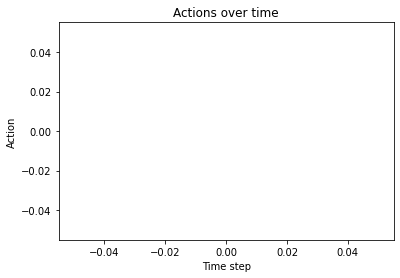

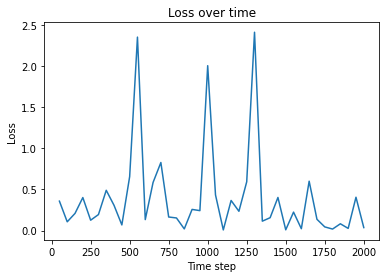

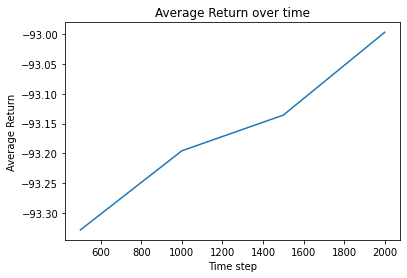

In [60]:
plot_results(behavioral_losses, behavioral_average_returns)